In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### Read data

In [2]:
def get_data(path, batch_size, is_train, should_shuffle):
    dataset = datasets.FashionMNIST(
        path,
        train=is_train,
        download=True,
        transform=transforms.ToTensor()
    )
    return torch.utils.data.DataLoader(
        dataset=dataset, 
        batch_size=batch_size, 
        shuffle=should_shuffle
    )

In [3]:
batch_size = 64

train_loader = get_data('./data_train', batch_size, True, True)
test_loader = get_data('./data_test', batch_size, False, False)

In [4]:
# check size of images
for X_train, y_train in train_loader:
    print(f'X_train: {X_train.shape}, {X_train.type()}')
    print(f'y_train: {y_train.shape}, {y_train.type()}')
    break

X_train: torch.Size([64, 1, 28, 28]), torch.FloatTensor
y_train: torch.Size([64]), torch.LongTensor


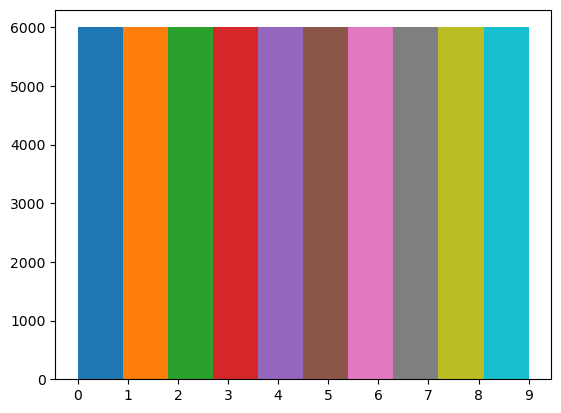

In [5]:
# check number of instances in each class
_, _, patches = plt.hist(train_loader.dataset.targets.numpy())
class_n = len(train_loader.dataset.classes)

plt.gca().set_xticks(range(class_n))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for i in range(class_n):
    patches[i].set_fc(colors[i])

plt.show()

In [6]:
img_side = 28
img_size_tuple = (img_side, img_side)
img_size = img_side * img_side

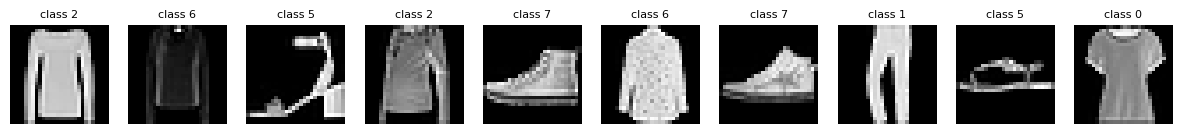

In [7]:
plt.figure(figsize=(15,15))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(img_size_tuple), cmap='gray')
    plt.title(f'class {y_train[i]}', fontsize=8)

plt.show()

### Create NN & train funs

In [8]:
class Net(nn.Module):
    
    def __init__(self, ):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(img_size, 50)
        self.fc1_drop = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = x.view(-1, img_size)
        
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        
        return F.log_softmax(self.fc3(x), dim=1)
    
##################################################
model = Net()
print(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()
##################################################

def train(epoch, log_interval):
    # switch model into train state
    model.train()
    
    for i, (data, target) in enumerate(train_loader):
        # reset gradient from previous step
        optimizer.zero_grad()
        
        # calculate prediction
        predictions = model(data)
        # calculate loss and gradient
        loss = criterion(predictions, target)
        loss.backward()
        
        # subtract gradient
        optimizer.step()
        
        if i % log_interval == 0:
            items_processed = i * len(data)
            items_total = len(train_loader.dataset)
            percent = 100 * items_processed / items_total
            print(f'epoch {epoch: 2}, {items_processed: 6}/{items_total}/{percent:2.0f}%, loss {loss.data:.3f}')
    
def metrics(loss, accuracy, loader, name):
    # switch model to evaluation state
    model.eval()
    
    # accumulate loss and number of correct predictions
    val_loss = 0
    correct = 0
    
    for data, target in loader:
        # calculate predictions
        predictions = model(data)
        # accumulate loss
        val_loss += criterion(predictions, target)
        # get class predictions from predictions
        predictions_only = predictions.data.max(1)[1]
        # accumulate correct predictions
        correct += predictions_only\
            .eq(target.data)\
            .to(torch.float32)\
            .sum()
    
    # len(loader) - returns number of batches
    # len(loader.dataset) - returns number of items in batch
    
    # calculate average loss. Loss was calcylated per batch => len(loader) => averager per batch
    val_loss /= len(loader)
    loss.append(val_loss.data.item())
    
    # accuracy was calculated per item => len(loader.dataset) => average per item
    accur = 100.0 * correct / len(loader.dataset)
    accuracy.append(accur.data.item())
    
    print(f'{name} set: avg loss={val_loss:.3f}, accuracy={accur:.3f}')

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


### Train

In [9]:
%%time
epochs = 120
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    train(epoch, 200)
    metrics(test_loss, test_accuracy, test_loader, 'test ')
    metrics(train_loss, train_accuracy, train_loader, 'train')
    print()

epoch  0,      0/60000/ 0%, loss 2.310
epoch  0,  12800/60000/21%, loss 1.552
epoch  0,  25600/60000/43%, loss 1.020
epoch  0,  38400/60000/64%, loss 0.959
epoch  0,  51200/60000/85%, loss 0.929
test  set: avg loss=0.747, accuracy=72.980
train set: avg loss=0.734, accuracy=73.510

epoch  1,      0/60000/ 0%, loss 0.699
epoch  1,  12800/60000/21%, loss 0.767
epoch  1,  25600/60000/43%, loss 0.679
epoch  1,  38400/60000/64%, loss 0.640
epoch  1,  51200/60000/85%, loss 0.933
test  set: avg loss=0.613, accuracy=78.210
train set: avg loss=0.590, accuracy=79.280

epoch  2,      0/60000/ 0%, loss 0.676
epoch  2,  12800/60000/21%, loss 0.569
epoch  2,  25600/60000/43%, loss 0.615
epoch  2,  38400/60000/64%, loss 0.508
epoch  2,  51200/60000/85%, loss 0.593
test  set: avg loss=0.542, accuracy=81.140
train set: avg loss=0.517, accuracy=82.102

epoch  3,      0/60000/ 0%, loss 0.503
epoch  3,  12800/60000/21%, loss 0.470
epoch  3,  25600/60000/43%, loss 0.532
epoch  3,  38400/60000/64%, loss 0.51

train set: avg loss=0.296, accuracy=89.305

epoch  29,      0/60000/ 0%, loss 0.279
epoch  29,  12800/60000/21%, loss 0.369
epoch  29,  25600/60000/43%, loss 0.326
epoch  29,  38400/60000/64%, loss 0.389
epoch  29,  51200/60000/85%, loss 0.485
test  set: avg loss=0.361, accuracy=86.960
train set: avg loss=0.294, accuracy=89.372

epoch  30,      0/60000/ 0%, loss 0.277
epoch  30,  12800/60000/21%, loss 0.458
epoch  30,  25600/60000/43%, loss 0.371
epoch  30,  38400/60000/64%, loss 0.333
epoch  30,  51200/60000/85%, loss 0.297
test  set: avg loss=0.362, accuracy=87.060
train set: avg loss=0.293, accuracy=89.268

epoch  31,      0/60000/ 0%, loss 0.461
epoch  31,  12800/60000/21%, loss 0.284
epoch  31,  25600/60000/43%, loss 0.396
epoch  31,  38400/60000/64%, loss 0.309
epoch  31,  51200/60000/85%, loss 0.407
test  set: avg loss=0.358, accuracy=87.210
train set: avg loss=0.289, accuracy=89.543

epoch  32,      0/60000/ 0%, loss 0.451
epoch  32,  12800/60000/21%, loss 0.438
epoch  32,  256

epoch  57,  38400/60000/64%, loss 0.232
epoch  57,  51200/60000/85%, loss 0.448
test  set: avg loss=0.345, accuracy=87.700
train set: avg loss=0.247, accuracy=90.810

epoch  58,      0/60000/ 0%, loss 0.306
epoch  58,  12800/60000/21%, loss 0.382
epoch  58,  25600/60000/43%, loss 0.372
epoch  58,  38400/60000/64%, loss 0.170
epoch  58,  51200/60000/85%, loss 0.481
test  set: avg loss=0.339, accuracy=87.820
train set: avg loss=0.242, accuracy=91.187

epoch  59,      0/60000/ 0%, loss 0.271
epoch  59,  12800/60000/21%, loss 0.559
epoch  59,  25600/60000/43%, loss 0.354
epoch  59,  38400/60000/64%, loss 0.244
epoch  59,  51200/60000/85%, loss 0.298
test  set: avg loss=0.342, accuracy=87.910
train set: avg loss=0.246, accuracy=91.052

epoch  60,      0/60000/ 0%, loss 0.368
epoch  60,  12800/60000/21%, loss 0.322
epoch  60,  25600/60000/43%, loss 0.350
epoch  60,  38400/60000/64%, loss 0.297
epoch  60,  51200/60000/85%, loss 0.360
test  set: avg loss=0.341, accuracy=88.080
train set: avg l

epoch  86,  12800/60000/21%, loss 0.277
epoch  86,  25600/60000/43%, loss 0.082
epoch  86,  38400/60000/64%, loss 0.270
epoch  86,  51200/60000/85%, loss 0.314
test  set: avg loss=0.342, accuracy=88.000
train set: avg loss=0.218, accuracy=92.130

epoch  87,      0/60000/ 0%, loss 0.267
epoch  87,  12800/60000/21%, loss 0.284
epoch  87,  25600/60000/43%, loss 0.226
epoch  87,  38400/60000/64%, loss 0.182
epoch  87,  51200/60000/85%, loss 0.217
test  set: avg loss=0.361, accuracy=87.270
train set: avg loss=0.237, accuracy=91.183

epoch  88,      0/60000/ 0%, loss 0.275
epoch  88,  12800/60000/21%, loss 0.168
epoch  88,  25600/60000/43%, loss 0.229
epoch  88,  38400/60000/64%, loss 0.294
epoch  88,  51200/60000/85%, loss 0.343
test  set: avg loss=0.345, accuracy=87.650
train set: avg loss=0.220, accuracy=91.873

epoch  89,      0/60000/ 0%, loss 0.173
epoch  89,  12800/60000/21%, loss 0.293
epoch  89,  25600/60000/43%, loss 0.401
epoch  89,  38400/60000/64%, loss 0.246
epoch  89,  51200/6

epoch  114,  51200/60000/85%, loss 0.175
test  set: avg loss=0.343, accuracy=87.990
train set: avg loss=0.202, accuracy=92.580

epoch  115,      0/60000/ 0%, loss 0.369
epoch  115,  12800/60000/21%, loss 0.258
epoch  115,  25600/60000/43%, loss 0.361
epoch  115,  38400/60000/64%, loss 0.315
epoch  115,  51200/60000/85%, loss 0.383
test  set: avg loss=0.349, accuracy=87.950
train set: avg loss=0.209, accuracy=92.277

epoch  116,      0/60000/ 0%, loss 0.174
epoch  116,  12800/60000/21%, loss 0.374
epoch  116,  25600/60000/43%, loss 0.297
epoch  116,  38400/60000/64%, loss 0.178
epoch  116,  51200/60000/85%, loss 0.365
test  set: avg loss=0.345, accuracy=88.040
train set: avg loss=0.200, accuracy=92.787

epoch  117,      0/60000/ 0%, loss 0.343
epoch  117,  12800/60000/21%, loss 0.226
epoch  117,  25600/60000/43%, loss 0.172
epoch  117,  38400/60000/64%, loss 0.314
epoch  117,  51200/60000/85%, loss 0.154
test  set: avg loss=0.348, accuracy=87.760
train set: avg loss=0.204, accuracy=92.4

### Plot learning rate

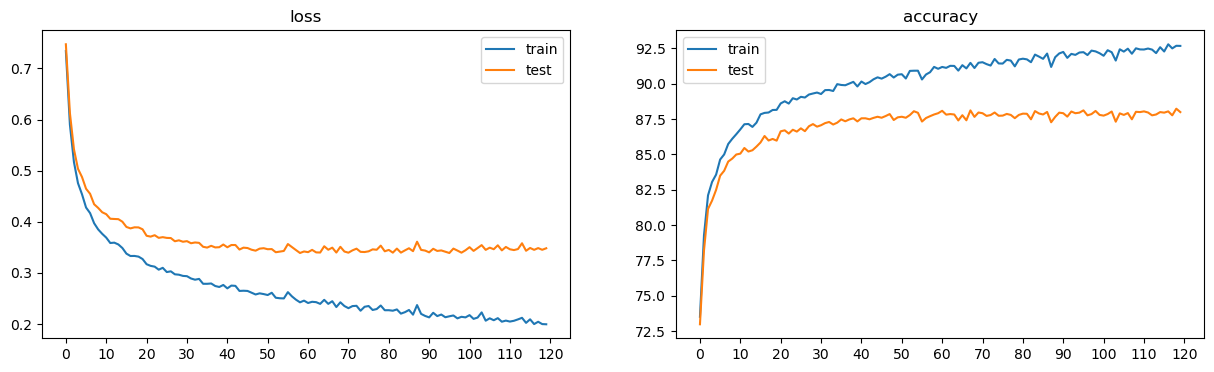

In [17]:
ticks = np.arange(0,len(train_accuracy)+1,10)

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend(loc='upper right')
plt.gca().set_xticks(ticks)
plt.title('loss')

# accuracy can be used, since classes have same size
plt.subplot(1,2,2)
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.legend(loc='upper left')
plt.gca().set_xticks(ticks)
plt.title('accuracy')

plt.show()

In [20]:
print(f'epoch with smallest test error: {np.argmin(test_loss)}')
print(f'epoch with highest test accuracy: {np.argmax(test_accuracy)}')

epoch with smallest test error: 95
epoch with highest test accuracy: 118
